In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras import optimizers
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from keras import regularizers

Using TensorFlow backend.
/Users/YoYoYe/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
file_path = "us_crude_oil.csv"
data_csv = pd.read_csv(file_path)
data_csv = data_csv[::-1].reset_index(drop=True)

train_end =200
total_data=len(data_csv)

data_csv.head()

,Date,US Production,US Import,US Exports,US Net Import,Inventory,Adjustment,Import from OPEC,Crude Oil and Liquid Fuels Supply,OPEC Production Capacity,Net Inventory Withdrawals,OPEC Production,Value,Nominal
0,1/31/94,6816779.0,5945000,110000,5835290.0,338067000.0,733963.032,2892000,9454972.161,27959177.0,-658883.053,24493494.87,24.80,14.48
1,2/28/94,6770326.0,6313000,116000,6197498.0,335351000.0,77211.714,3237000,9313861.429,27959177.0,2352418.325,24477904.76,25.25,14.79
2,3/31/94,6745622.0,6372000,41000,6331468.0,342345000.0,242361.355,3006000,9380460.548,27959177.0,880568.964,24520851.10,28.80,16.90
3,4/30/94,6612102.0,6955000,120000,6835867.0,339391000.0,302264.000,3728000,9303302.667,27959177.0,-734538.343,24370063.76,31.18,18.31
4,5/31/94,6688193.0,7198000,118000,7080258.0,331544000.0,259904.258,3771000,9339128.968,27959177.0,-2706335.628,24513404.04,32.89,19.37


In [3]:
yt = data_csv.iloc[0:total_data,12]    #Price data
yt_ = yt.shift (-1)   
print(yt_)

data = pd.concat([yt, yt_], axis=1)
data.columns = ['yt', 'yt_']
data.head()

0      25.25
1      28.80
2      31.18
3      32.89
4      34.37
5      29.61
6      30.93
7      30.56
8      30.29
9      29.80
10     30.75
11     30.79
12     31.80
13     33.71
14     31.19
15     28.66
16     28.92
17     29.31
18     28.77
19     28.84
20     29.74
21     32.00
22     28.86
23     31.69
24     34.65
25     34.07
26     31.70
27     33.53
28     32.67
29     35.53
       ...  
269    46.62
270    50.22
271    48.69
272    51.47
273    55.92
274    54.66
275    55.68
276    52.12
277    50.66
278    49.62
279    47.24
280    51.47
281    48.32
282    52.60
283    55.41
284    58.49
285    61.57
286    65.64
287    62.19
288    65.39
289    68.78
290    66.97
291    73.93
292    68.55
293    69.52
294    72.88
295    64.85
296    50.78
297    45.41
298      NaN
Name: Value, Length: 299, dtype: float64


,yt,yt_
0,24.80,25.25
1,25.25,28.80
2,28.80,31.18
3,31.18,32.89
4,32.89,34.37


In [4]:
N=20    
cols =['yt']
for i in range (N):
    data['yt'+str(i)] = list(yt.shift(i+1))
    cols.append('yt'+str(i))
    
data = data.dropna()
data_original = data
data = data.diff()
data = data.dropna()
 
# target variable - Price
# after shifting
y = data['yt_']
x = data[cols]

print(y.head())
print(x.head())

21    2.26
22   -3.14
23    2.83
24    2.96
25   -0.58
Name: yt_, dtype: float64
      yt   yt0   yt1   yt2   yt3   yt4   yt5   yt6   yt7   yt8  ...   yt10  \
21  0.90  0.07 -0.54  0.39  0.26 -2.53 -2.52  1.91  1.01  0.04  ...  -0.49   
22  2.26  0.90  0.07 -0.54  0.39  0.26 -2.53 -2.52  1.91  1.01  ...   0.95   
23 -3.14  2.26  0.90  0.07 -0.54  0.39  0.26 -2.53 -2.52  1.91  ...   0.04   
24  2.83 -3.14  2.26  0.90  0.07 -0.54  0.39  0.26 -2.53 -2.52  ...   1.01   
25  2.96  2.83 -3.14  2.26  0.90  0.07 -0.54  0.39  0.26 -2.53  ...   1.91   

    yt11  yt12  yt13  yt14  yt15  yt16  yt17  yt18  yt19  
21 -0.27 -0.37  1.32 -4.76  1.48  1.71  2.38  3.55  0.45  
22 -0.49 -0.27 -0.37  1.32 -4.76  1.48  1.71  2.38  3.55  
23  0.95 -0.49 -0.27 -0.37  1.32 -4.76  1.48  1.71  2.38  
24  0.04  0.95 -0.49 -0.27 -0.37  1.32 -4.76  1.48  1.71  
25  1.01  0.04  0.95 -0.49 -0.27 -0.37  1.32 -4.76  1.48  

[5 rows x 21 columns]


In [5]:
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x = np.array(x).reshape((len(x),len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y = np.array(y).reshape((len(y), 1))
y = scaler_y.fit_transform(y)

    
x_train = x[0: train_end,]
x_test = x[train_end +1:len(x),]    
y_train = y[0: train_end] 
y_test = y[train_end +1:len(y)]  

x_train = x_train.reshape(x_train.shape + (1,)) 
x_test = x_test.reshape(x_test.shape + (1,))

In [6]:
model = Sequential()
model.add(LSTM(400, activation='relu', inner_activation='hard_sigmoid' , bias_regularizer=L1L2(l1=0.01, l2=0.01),  input_shape = (len(cols), 1), return_sequences=False))
model.add(Dense(output_dim=1, activation='linear', activity_regularizer=regularizers.l1(0.01)))
adam=optimizers.Adam(lr=0.01, beta_1=0.89, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss="mean_squared_error" , optimizer="adam") 
history=model.fit(x_train, y_train, batch_size=1, nb_epoch=50, shuffle=False, validation_split=0.15)

/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(400, activation="relu", bias_regularizer=<keras.reg..., input_shape=(21, 1), return_sequences=False, recurrent_activation="hard_sigmoid")`
  
/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", activity_regularizer=<keras.reg..., units=1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 170 samples, validate on 30 samples
Epoch 1/50
170/170 [==============================] - 9s 51ms/step - loss: 7.1242 - val_loss: 6.2856
Epoch 2/50
170/170 [==============================] - 7s 41ms/step - loss: 5.3915 - val_loss: 4.6819
Epoch 3/50
170/170 [==============================] - 7s 40ms/step - loss: 3.9583 - val_loss: 3.3806
Epoch 4/50
170/170 [==============================] - 7s 42ms/step - loss: 2.7880 - val_loss: 2.3241
Epoch 5/50
170/170 [==============================] - 7s 43ms/step - loss: 1.8443 - val_loss: 1.4739
Epoch 6/50
170/170 [==============================] - 8s 47ms/step - loss: 1.0936 - val_loss: 0.8117
Epoch 7/50
170/170 [==============================] - 8s 47ms/step - loss: 0.5103 - val_loss: 0.3019
Epoch 8/50
170/170 [==============================] - 7s 43ms/step - loss: 0.1172 - val_loss: 0.1051
Epoch 9/50
170/170 [==============================] - 7s 44ms/step - loss: 0.0673 - val_loss: 0.1009
Epoch 10/50
170/170 [=========================

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               643200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'loss'])


/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


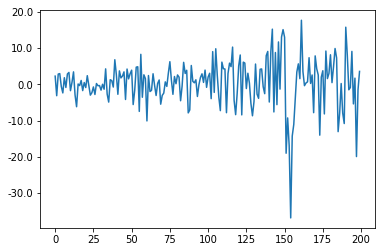

In [7]:
y_train_back=scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train),1)))
plt.figure(1)
plt.plot(y_train_back)
fmt = '%.1f'
tick = mtick.FormatStrFormatter(fmt)
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
print (model.summary())
print(history.history.keys())

/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


76/76 [==============================] - 1s 7ms/step
 in train MSE =  0.072
 in test MSE =  0.050687612941194525
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 400)               643200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 643,601
Trainable params: 643,601
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 21, 1)
Outputs: (None, 1)
Actual input: (76, 21, 1)
Actual output: (76, 1)
prediction data:
[-2.2047648]
y_test:
[[ -5.13]
 [ -6.46]
 [  3.34]
 [  3.45]
 [  5.91]
 [ -6.76]
 [  5.31]
 [ -3.97]
 [ -1.7 ]
 [  4.66]
 [  9.11]
 [  2.61]
 [ -5.82]
 [ -6.1 ]
 [ -3.75]
 [  6.15]
 [ -1.4 ]
 [  5.07]
 [ -1.79]
 [ -2.26]
 [  2.74]
 [  2.6 ]
 [ -7.59]
 [ -2.14]
 [ -5.16]
 [-10.96]
 [-14.83]
 [-13.38]
 [ -5.14]
 

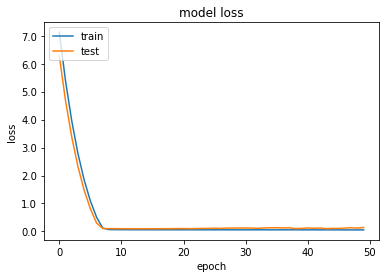

In [8]:
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fmt = '%.1f'
tick = mtick.FormatStrFormatter(fmt)
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)

score_train = model.evaluate(x_train, y_train, batch_size=1)
score_test = model.evaluate(x_test, y_test, batch_size=1)
print (" in train MSE = ", round(score_train,4)) 
print (" in test MSE = ", score_test)

pred1 = model.predict(x_test) 
pred1 = scaler_y.inverse_transform(np.array(pred1). reshape((len(pred1),1)))
 
prediction_data = pred1[-1]     
model.summary()
print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(x_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test),1)))
print ("y_test:")
print (y_test)

act_data = np.array([row[0] for row in y_test])

fmt = '%.1f'
tick = mtick.FormatStrFormatter(fmt)
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)

plt.savefig("LSTM_model_loss.png")

act_data:
[ -5.13  -6.46   3.34   3.45   5.91  -6.76   5.31  -3.97  -1.7    4.66
   9.11   2.61  -5.82  -6.1   -3.75   6.15  -1.4    5.07  -1.79  -2.26
   2.74   2.6   -7.59  -2.14  -5.16 -10.96 -14.83 -13.38  -5.14   1.38
  -2.59  12.68   0.35  -1.06 -13.     2.24  -4.24   1.58  -5.09  -4.77
  -3.7    0.14   4.67   7.77   3.14  -1.    -6.93   3.19   3.6   -1.53
   2.78   4.45  -1.26   1.02  -3.56  -1.46  -1.04  -2.38   4.23  -3.15
   4.28   2.81   3.08   3.08   4.07  -3.45   3.2    3.39  -1.81   6.96
  -5.38   0.97   3.36  -8.03 -14.07  -5.37]
pred1:
[[ 2.1905107 ]
 [-0.87537825]
 [-2.173851  ]
 [-2.6796577 ]
 [-2.2222672 ]
 [-1.1969242 ]
 [-0.75989056]
 [ 2.132675  ]
 [ 1.5427333 ]
 [ 2.867228  ]
 [ 1.5510105 ]
 [ 0.5790147 ]
 [-1.3380973 ]
 [-1.7701033 ]
 [-1.137304  ]
 [-0.6081037 ]
 [-2.559314  ]
 [-2.1211665 ]
 [-2.0739632 ]
 [-0.14744152]
 [-2.5833578 ]
 [-1.4349817 ]
 [-1.7433554 ]
 [-2.1826258 ]
 [-2.0192707 ]
 [-1.3178014 ]
 [ 0.07652818]
 [-2.727584  ]
 [-2.3896596 ]
 [ 1.42

/Users/YoYoYe/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


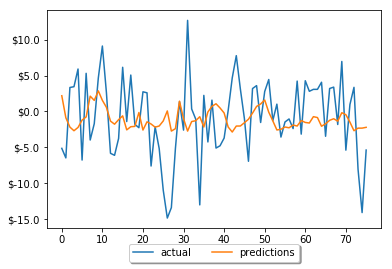

In [9]:
plt.figure(3)
plt.plot(y_test, label="actual")
plt.plot(pred1, label="predictions")

print ("act_data:")
print (act_data)

print ("pred1:")
print (pred1)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
fmt = '$%.1f'
tick = mtick.FormatStrFormatter(fmt)
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)

def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Store the prediction made on each test window
    moving_test_window = [x_test[0,:].tolist()]          # First test window
    moving_test_window = np.array(moving_test_window)    
   
    for i in range(n_future_preds):
      
      
        preds_one_step = model.predict(moving_test_window) 
        preds_moving.append(preds_one_step[0,0]) 
                       
        preds_one_step = preds_one_step.reshape(1,1,1) 
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        

    print ("pred moving before scaling:")
    print (preds_moving)
                                         
    preds_moving = scaler_y.inverse_transform((np.array(preds_moving)).reshape(-1, 1))
    
    print ("pred moving after scaling:")
    print (preds_moving)
    return preds_moving
    
print("do moving test predictions for next 22 days:")    
preds_moving = moving_test_window_preds(22)

count_correct=0
error =0

try:
    for i in range (len(y_test)):
        error=error + ((y_test[i]-preds_moving[i])**2) / y_test[i]
        if y_test[i] >=0 and preds_moving[i] >=0 :
            count_correct=count_correct+1
        if y_test[i] < 0 and preds_moving[i] < 0 :
            count_correct=count_correct+1
except:pass

plt.savefig("lstm_actvspre.png")

accuracy_in_change:
0.14473684210526316


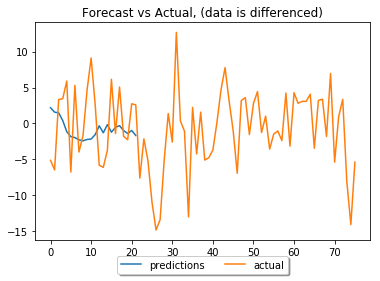

In [12]:
accuracy_in_change =  count_correct / (len(y_test))

plt.figure(4)
plt.title("Forecast vs Actual, (data is differenced)")          
plt.plot(preds_moving, label="predictions")
plt.plot(y_test, label="actual")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)


print ("accuracy_in_change:")
print (accuracy_in_change)

ind=data_original.index.values[0] + data_original.shape[0] -len(y_test)-1
prev_starting_price = data_original.loc[ind,"yt_"]
preds_moving_before_diff =  [0 for x in range(len(preds_moving))]

for i in range (len(preds_moving)):
    if (i==0):
        preds_moving_before_diff[i]=prev_starting_price + preds_moving[i]
    else:
        preds_moving_before_diff[i]=preds_moving_before_diff[i-1]+preds_moving[i]


y_test_before_diff = [0 for x in range(len(y_test))]

for i in range (len(y_test)):
    if (i==0):
        y_test_before_diff[i]=prev_starting_price + y_test[i]
    else:
        y_test_before_diff[i]=y_test_before_diff[i-1]+y_test[i]
        
plt.savefig("lstm_forecastvsactdif.png")

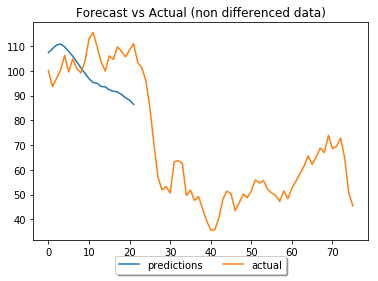

In [11]:
plt.figure(5)
plt.title("Forecast vs Actual (non differenced data)")
plt.plot(preds_moving_before_diff, label="predictions")
plt.plot(y_test_before_diff, label="actual")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
plt.savefig("lstm_forecastvsactnondif.png")